## Quantitative phase analysis (QPA)
Fox/ObjCryst++ was not designed with QPA in mind, but it
is still possible to do it when the phases are known
and the profiles not too complicated.

Here we just try the 'simple' cases of the QPA Round Robin of
1999 (https://www.iucr.org/__data/iucr/powder/QARR/index.html)

In [1]:
# 'widget' allows live update and works in both classical notebooks and jupyter-lab.
# Otherwise 'notebook', 'ipympl', 'inline' can be used
%matplotlib widget

import os
import pyobjcryst
import numpy as np
import matplotlib.pyplot as plt
from pyobjcryst.crystal import *
from pyobjcryst.powderpattern import *
from pyobjcryst.indexing import *
from pyobjcryst.molecule import *
from pyobjcryst.globaloptim import MonteCarlo
from pyobjcryst.io import xml_cryst_file_save_global
from pyobjcryst.lsq import LSQ
from pyobjcryst.refinableobj import refpartype_scattdata_scale

### Data and CIF sources

In [2]:
# Data from QPA round-robin
# https://www.iucr.org/__data/iucr/powder/QARR/samples.htm
#  & Crystal structures from the Crystallography Open Database
# Try samples 1a to 1h
data_file = "cpd-1h.prn"
cod_phases = [1000032, 9008877, 5000222] # Al2O3, ZnO, CaF2 - needs checking

### Create Powder pattern

1.5418366591135662
Imported powder pattern: 7251 points, 2theta=  5.000 -> 150.000, step= 0.020


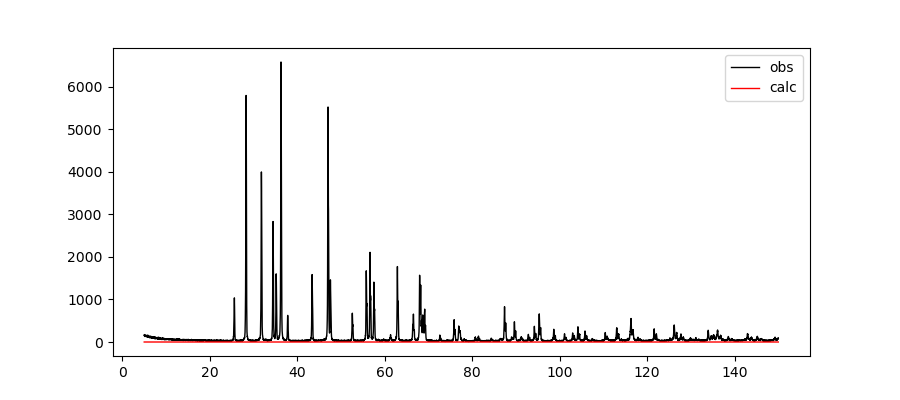

In [3]:
p = PowderPattern()
if not os.path.exists(data_file):
    os.system("curl -O -q -H \"User-Agent: Mozilla/5.0 (Windows NT 11.0; Win64; x64)\" https://www.iucr.org/__data/iucr/powder/QARR/col/%s" % data_file)

p.ImportPowderPattern2ThetaObs(data_file)
# Copper K-alpha1+alpha2. Use "Cua1" for Cu-alpha1 only
p.SetWavelength("Cu")
print(p.GetWavelength())

p.plot(hkl=True)

### Add crystalline phases
We assume all structures are known.

This will update the above plot, though the scales will be incorrect.

In [4]:
for cod_id in cod_phases:
    c = CreateCrystalFromCIF("http://crystallography.net/cod/%d.cif" % cod_id)
    #print(c,"\n")
    p.AddPowderPatternDiffraction(c)

p.FitScaleFactorForRw()
p.UpdateDisplay()

========================== WARNING =========================
   In ScatteringPowerAtom::GetTemperatureFactor():
   Anisotropic Displacement Parameters are not currently properly handled
   for Debye-Waller calculations (no symmetry handling for ADPs).
   =>The Debye-Waller calculations will instead use only isotropic DPs



### Add an automatic background
This uses a Bayesian estimation of the background, which should be
good enough if there is a good separation of the peaks

In [5]:
# Add background if necessary
need_background = True
for i in range(p.GetNbPowderPatternComponent()):
    if isinstance(p.GetPowderPatternComponent(i), PowderPatternBackground):
        need_background = False
        break
if need_background:
    print("No background, adding one automatically")
    x = p.GetPowderPatternX()
    bx = np.linspace(x.min(), x.max(), 30)  # Number of interpolation points
    by = np.zeros(bx.shape)
    b = p.AddPowderPatternBackground()
    b.SetInterpPoints(bx, by)
    # b.Print()
    b.UnFixAllPar()
    b.OptimizeBayesianBackground()
p.UpdateDisplay()

No background, adding one automatically


### Fit profile, step 1
Conservative fit, starting with a fixed width (W=1e-5) 

Note that as we know the crystalline structures, we don't need to perform a Le Bail fit

In [6]:
# Multiple phases, so can't use quick_fit_profile
#
# NOTE: we don't use this function as the phases are known, but that's the way
# to do it with multiple crystalline phases
def do_lebail(init=False):
    """
    This performs a Le Bail fit by looping over all phases,
    one at a time. Le Bail is disabled on output
    """
    for i in range(20):
        for i in range(p.GetNbPowderPatternComponent()):
            pdiff = p.GetPowderPatternComponent(i)
            if not isinstance(pdiff, PowderPatternDiffraction):
                continue
            if i==0 or init:
                pdiff.SetExtractionMode(True, True)
            else:
                pdiff.SetExtractionMode(True, False)
            pdiff.ExtractLeBail(1)
            pdiff.SetExtractionMode(False, False)


In [7]:
for i in range(p.GetNbPowderPatternComponent()):
    pdiff = p.GetPowderPatternComponent(i)
    if not isinstance(pdiff, PowderPatternDiffraction):
        continue
    pdiff.SetReflectionProfilePar(ReflectionProfileType.PROFILE_PSEUDO_VOIGT, 0.00001)

p.UpdateDisplay()


### Fit profile, step 2
Refine only constant width, zero, Eta Gaussian/Voigt mix, and a, b, c parameters 

In [8]:
lsq = LSQ()
lsq.SetRefinedObj(p, 0, True, True)
lsq.PrepareRefParList(True)
# lsq.GetCompiledRefinedObj().Print()
lsqr = lsq.GetCompiledRefinedObj()

lsqr.FixAllPar()
# lsqr.Print()
# print(lsq.ChiSquare())
lsq.SetParIsFixed(refpartype_scattdata_scale, False)
for par in ["W", "Zero", "Eta0", "a", "b", "c"]:
    for i in range(p.GetNbPowderPatternComponent()):
        # This is a KLUDGE - we need this because parameter names are
        # unique, and thus "U" gets renamed to "U~", "U~~" in case of 2,3 phases.. 
        lsq.SetParIsFixed(par + "~"*i, False)
lsq.SafeRefine(nbCycle=10, useLevenbergMarquardt=True, silent=True)

p.UpdateDisplay()


### Fit profile, final
Refine more parameters, and fit the scale factor

In [9]:
lsqr.FixAllPar()
# lsqr.Print()
# print(lsq.ChiSquare())
lsq.SetParIsFixed(refpartype_scattdata_scale, False)
for par in ["U", "V", "W", "Zero", "Eta0", "Eta1", "a", "b", "c", "2ThetaDispl", "2ThetaTransp"]:
    for i in range(p.GetNbPowderPatternComponent()):
        # This is a KLUDGE - we need this because parameter names are
        # unique, and thus "U" gets renamed to "U~", "U~~" in case of 2,3 phases.. 
        lsq.SetParIsFixed(par + "~"*i, False)
lsq.SafeRefine(nbCycle=10, useLevenbergMarquardt=True, silent=True)

p.FitScaleFactorForRw()
p.UpdateDisplay()


### Compute weight percentages
This uses the formula: 
$w_i = \frac{S_iZ_iM_iV_i}{\Sigma_iS_iZ_iM_iV_i}$

where:
* $w_i$ is the weight fraction of crystalline phase i
* $S_i$ its scale factor in the Rietveld refinement
* $Z_i$ the multiplicity of the formula in the unit cell
* $M_i$ the crystal formula's molecular weight
* $V_i$ the unit cell volume for the phase

This assumes that the structure is known (and thus that the
CIF files are correct), and that we know all present phases.

The obtained numbers can be compared to:
https://www.iucr.org/__data/iucr/powder/QARR/results.htm

In [10]:
# TODO: check if the method is correctly applied, notably
# is there a shortcut in ObjCryst++ so that the calculated
# structure factor sometimes skips a factor 2 (centrosymmetry
# or other centering factors which allow to avoid a direct sum)

w = p.qpa(verbose=True)

Weight percentages:
Aluminium oxide - $-alpha:  37.42%
                  Zincite:  28.35%
         Calcium fluoride:  34.23%
